**首先**，我们需要安装一些必要的Python库，比如numpy和matplotlib，用于生成随机数和绘图。

In [1]:
!pip install numpy matplotlib mplfinance

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/75.0 kB ? eta -:--:--
     -------------------------------- ------- 61.4/75.0 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 75.0/75.0 kB 830.5 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


**然后**，我们可以开始编写代码。

定义机器人及设置初始环境

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 设置随机种子以确保结果可复现
seed = np.random.randint(0,10000000)
print(f'随机种子：{seed}')
np.random.seed(seed)

# 定义机器人类
class Robot:
    def __init__(self, cash, position):
        self.cash = cash  # 现金量
        self.position = position  # 持仓量

# 市场参数
num_robots = 50  # 机器人数量

# 交易记录
trading_days = 250  # 交易天数
trading_hours = 4  # 交易小时数
trading_minutes = trading_hours * 60  # 每个交易日的分钟数
price变动范围 = 0.005  # 价格变动范围
transactions = pd.DataFrame(columns=['time', 'open', 'high', 'low', 'close', 'volume'])

def matchmarketing_tradeoff(buy_sell_df):
    # 假设'buy_sell_df'是您已经准备好的DataFrame
    # 首先，我们需要将买入和卖出的数量转换为正数，并且剔除NaN值
    buy_sell_df['buy'] = buy_sell_df['buy'].abs()
    buy_sell_df['sell'] = buy_sell_df['sell'].abs()

    # 按照quote价格从低到高排序
    buy_sell_df = buy_sell_df.sort_values('quote')

    # 初始化变量
    final_trade_price = None
    final_trade_volume = 0

    # 计算每个价格以上的买入总量和每个价格以下的卖出总量
    buy_sell_df['cumulative_buy'] = buy_sell_df['buy'][::-1].cumsum()[::-1]-buy_sell_df['buy']
    buy_sell_df['cumulative_sell'] = buy_sell_df['sell'].cumsum()
    buy_sell_df['cumulative_buy1'] = buy_sell_df['buy'][::-1].cumsum()[::-1]
    buy_sell_df['cumulative_sell1'] = buy_sell_df['sell'].cumsum()-buy_sell_df['sell']
    buy_sell_df['gap'] = buy_sell_df['cumulative_buy'] - buy_sell_df['cumulative_sell']
    buy_sell_df['gap1'] = buy_sell_df['cumulative_buy1'] - buy_sell_df['cumulative_sell1']

    # 找到成交价和成交量
    for index, row in buy_sell_df.iterrows():
        gap = row['cumulative_buy'] - row['cumulative_sell']
        gap1 = row['cumulative_buy1'] - row['cumulative_sell1']
        if gap <= 0 and abs(gap) <= row['buy']:
            final_trade_price = row['quote']
            final_trade_volume = row['cumulative_sell']
            break
        elif gap1 >= 0 and abs(gap1) <= row['sell']:
            final_trade_price = row['quote']
            final_trade_volume = row['cumulative_buy1']
            break
    return final_trade_price,final_trade_volume


随机种子：1689581


**第二步**，模拟交易

In [4]:
# 假设当前价格和价格变动范围已经确定
current_price = 1.000  # 当前价格
price_movement_range = 0.002  # 价格变动范围，即标准差
transactions = pd.DataFrame(columns=['time', 'open','high','low','close','volume'])
# 模拟交易
for day in range(trading_days):
    price_list = []
    volume_list = []
    for minute in range(trading_minutes):
        # 机器人初始化
        robots = []
        for _ in range(num_robots):
            cash = np.random.randint(2,40)  # 现金量符合正态分布
            position = np.random.randint(2,40)  # 持仓量
            robots.append(Robot(cash, position))

        # 机器人决定交易行为
        actions = np.random.choice(['buy', 'sell', 'hold'], num_robots, p=[0.33, 0.33, 0.34])
        amounts = [None] * num_robots

        # 机器人执行交易
        for i, action in enumerate(actions):
            if action == 'buy':
                rd = np.random.randint(0,robots[i].cash/current_price)
                amounts[i] = rd
            elif action == 'sell':
                rd = np.random.randint(0,robots[i].position)
                amounts[i] = -rd



        # 生成符合正态分布的报价数组
        # 均值为当前价格，标准差为价格变动范围
        quotes = np.random.normal(current_price, price_movement_range*current_price, num_robots)

        # 为了确保报价不会低于最小价格或高于最大价格，我们需要对生成的报价进行限制
        quotes = np.clip(quotes, current_price * np.exp(-price_movement_range), current_price * np.exp(price_movement_range))
        quotes = np.around(quotes,decimals=3)
        pd.options.display.max_columns = None
        pd.options.display.max_rows = None
        robot_quotes_df = pd.DataFrame({"action":actions,"quote":quotes,"amount":amounts})

        # 假设您已经有了DataFrame 'robot_quotes_df'
        # 首先，剔除'action'为'hold'的行
        df = robot_quotes_df[robot_quotes_df['action'] != 'hold']

        # 接着，分别计算每个'quote'的买入和卖出总量
        buy_sell_df = df.groupby('quote').agg(
            buy=('amount', lambda x: x[x > 0].sum()),
            sell=('amount', lambda x: x[x < 0].sum())
        ).reset_index()

        # 如果您需要将NaN替换为0
        buy_sell_df = buy_sell_df.fillna(0)

        # 输出最终的成交价和成交量
        final_trade_price,final_trade_volume = matchmarketing_tradeoff(buy_sell_df)
        #print(f"最终成交价: {final_trade_price}, 最终成交量: {final_trade_volume}")
        current_price = final_trade_price
        price_list.append(final_trade_price)
        volume_list.append(final_trade_volume)
        
    # 记录交易信息
    # 创建一个新的DataFrame来记录交易信息
    price_list = price_list[30:]
    new_transaction = pd.DataFrame({
        'time': [day],
        'open': [price_list[0]],  # 假设开盘价等于当前价格
        'high': [np.max(quotes)],  # 最高价
        'low': [np.min(quotes)],  # 最低价
        'close': [price_list[-1]],  # 收盘价
        'volume': [sum(volume_list)]
    })

    # 使用concat方法将新的交易信息添加到transactions DataFrame中
    transactions = pd.concat([transactions, new_transaction], ignore_index=True)


**最后**，生成k线图

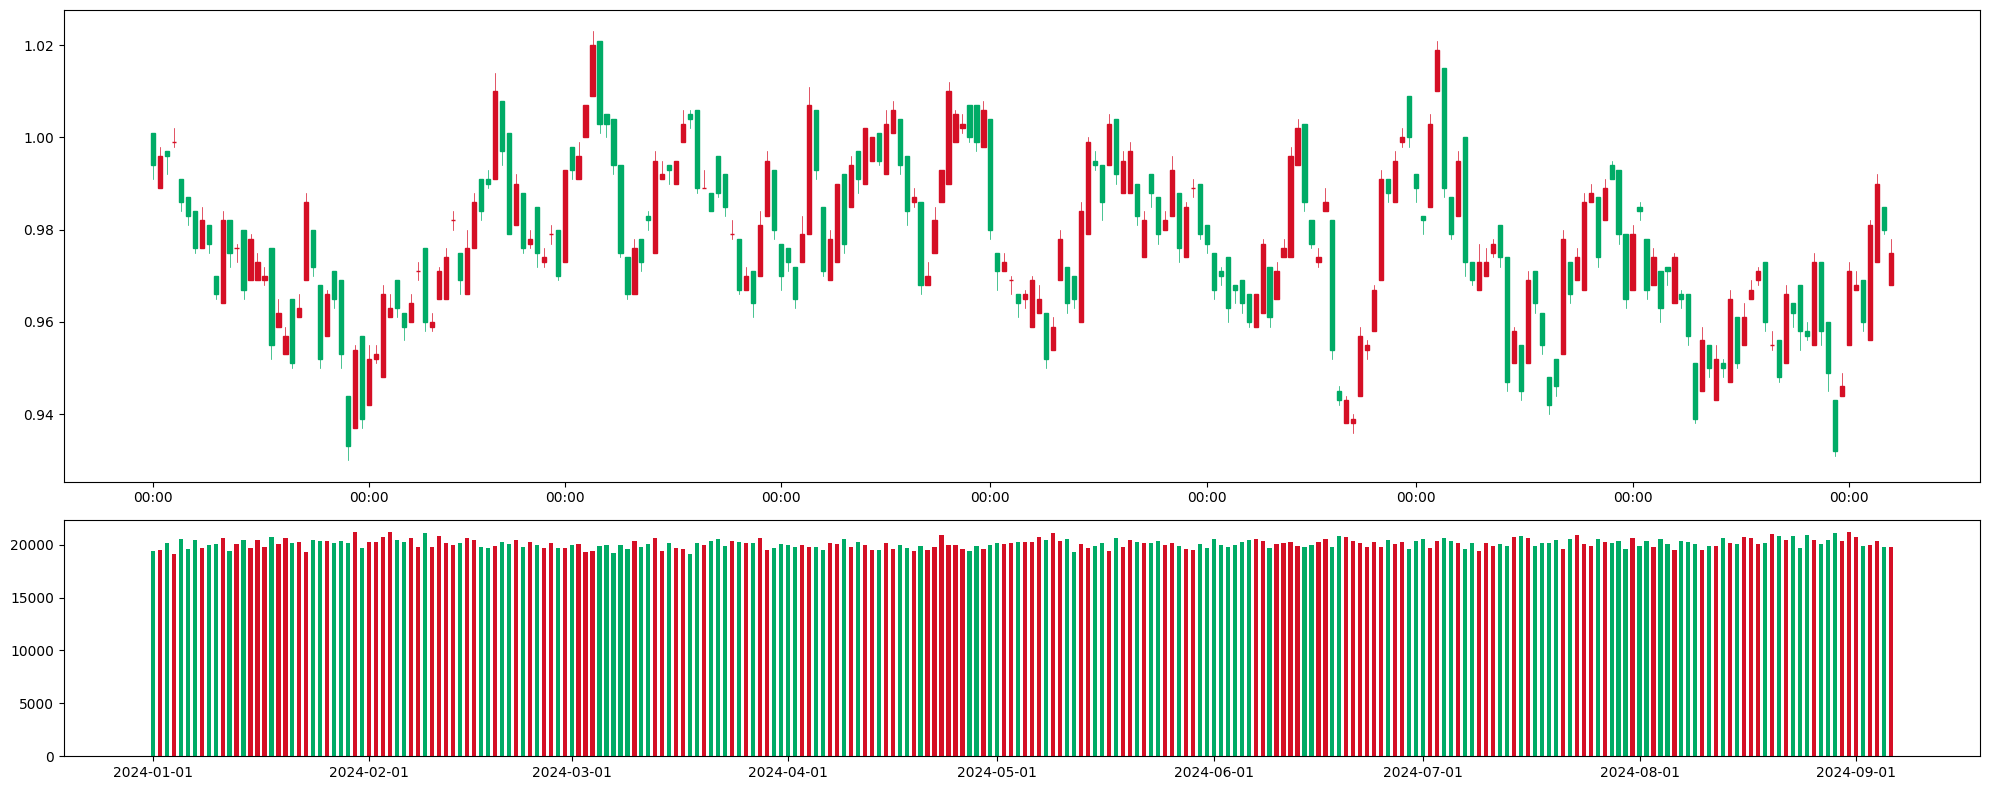

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# 将时间转换为matplotlib的日期格式
transactions['date'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(transactions['time'], unit='D')

# 设置绘图区域大小，并创建两个子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8), gridspec_kw={'height_ratios': [2, 1]})

# 绘制K线图
candlestick_ohlc(ax1, transactions.values, width=0.6, colorup='#d50f25', colordown='#00ab66')

# 设置x轴为日期格式
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# 根据'close'和'open'的值确定柱状图的颜色
colors = ['#d50f25' if close >= open else '#00ab66' for close, open in zip(transactions['close'], transactions['open'])]

# 绘制成交量柱状图，颜色由colors列表决定
ax2.bar(transactions['date'], transactions['volume'], color=colors, width=0.6)

# 设置x轴为日期格式
ax2.xaxis_date()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()
